# Pursuit Evasion Game Evolutionary Algorithm

### Pursuit Evasion Games

Pursuit Evasion Games are a subclass of non-cooperative games. The simplest case includes a pursuer and an evader, which in our case are referred to as the predator and prey respectively. The pursuer's objective is to catch the evader, while the evader must avoid capture. This is a zero-sum game of competing interests. The characteristics of the two players are different. In our experiment we give the predator an advantage in top speed, whereas the prey has an agility advantage, encoded as having a higher acceleration. 

### Game Structure
The game has been defined in the `game.py` file, where we also added functionality to simulate, plot, and analyze the results of the game. The game is imported here as `PredatorPreyGame`. The purpose of this study is to explore the best behavior the prey can have to escape from the predator.

In [1]:
# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from typing import List, Tuple
import seaborn as sns

from game import PredatorPreyGame
from game_plot import visualize_best_simulation, visualize_evolution, visualize_trait_distributions

## Genomes

The first step to evolution is a basic structure to hold the genetic information of the individuals. For this reason, a unqiue genome needs to be defined for the prey and predator. The prey and predator classes are already defined in `game.py`, with an initial position as well as a max speed for both. These will give us a starting basis to model the game from. The predator will start at (0,0) with a max speed of 3.0, while the prey will start at (15,15) with a speed of 1.0. The prey does not travel at its max speed until it is interrupted from wandering by the predator onset.

#### Prey Genome
The prey genome is characterized by a `react_radius`, a radius around the prey which initiates the reaction once the predator is in it, an `evasion_angle`, the direction the prey will move to evade, and finally the `evasion_time`, the cooldown of the evasion the prey has. The values are intialized, but they will be generated in the following section to explore the parameter space.

In [2]:
class PreyGenome:
    def __init__(self):
        self.react_radius = 10.0
        self.evasion_angle = np.pi/2
        self.evasion_time = 3.0

### Simulation Runner

The `run_simulation` function will serve as our simulation engine, taking a prey genome and simulation parameters to run a complete predator-prey chase scenario. It creates a new game instance with the specified prey genome and runs the simulation until either:
- The predator catches the prey (`game.game_over` becomes True)
- The maximum simulation time is reached

The function returns the completed game object, which contains all the simulation data needed for fitness evaluation.

In [3]:
def run_simulation(prey_genome, simulation_params):
    game = PredatorPreyGame(width=simulation_params['width'], height=simulation_params['height'], prey_genome=prey_genome,
                            pred_max_speed=simulation_params['pred_max_speed'], prey_max_speed=simulation_params['prey_max_speed'])

    while not game.game_over and game.time_elapsed < simulation_params['max_time']:
        game.update(dt=simulation_params['dt'])
    
    return game

## Fitness Function

The next important part of an evolutionary algorithm is the fitness function, to quantify how well the current genetic combination of prey and predator are performing. This metric will be important in deciding the "survival of the fittest", the best genomes that will go on to reproduce and create the new offspring of agents.

#### Prey Fitness Function
The fitness function quantifies how well the prey is able to evade the predator, therefore a natural choice in our game is the `survival_time` as well as the `normalized_distance`. The survival time tells us how long the prey was able to evade for, normalized by how long the game is allowed to go on for, and the distance will tell us how far the prey got, normalized by the diagonal length of the arena. Finally, a weighted sum of these two values is taken. The weights are passed into the fitness function to try different combinations to get the best result.

In [4]:
# Prey Fitness
def prey_fitness(game, max_time, time_w=0.5, dist_w=0.5):
    """
    Fitness function for prey: survival time
    """
    survival_time = game.get_survival_time()
    
    # Calculate distance from initial position to final position
    if len(game.prey_trail) < 1:
        final_distance = 0.0
    else:
        initial_x, initial_y = game.prey_trail[0]
        final_x, final_y = game.prey_trail[-1]
        final_distance = np.sqrt((final_x - initial_x)**2 + (final_y - initial_y)**2)
    
    normalized_survival_time = min(survival_time / max_time, 1.0)
    
    # Normalize final distance (max possible is arena diagonal)
    arena_diagonal = np.sqrt(game.width**2 + game.height**2)
    normalized_distance = min(final_distance / arena_diagonal, 1.0)
    
    # Weighted combination
    fitness = time_w * normalized_survival_time + dist_w * normalized_distance
    
    return fitness

## Variation Operators

Next we need to define the evolutionary operators, that are needed to generate new candidate solutions. The operators are divided into different types based on their arity, the number of inputs that go into the variation. The selection operator does not have an arity as it acts as more of a filtering operator, selecting a subset out of all individuals that will be able to reproduce.
- $\mathrm{Arity} = 1$: mutation operator
- $\mathrm{Arity} > 1$: recombination operator
- $\mathrm{Arity} = 2$: crossover operator

Our experiment will not be implementing crossover, instead we will focus on selection, mutation, and recombination.

#### Selection
Selection is the process of picking individuals from a population to serve as parents for the next generation of offspring. The operator evaluates the fitness of each individual and probabilistically favors those with higher fitness, guiding the evolutionary process toward better solutions. Selection does not modify the individuals themselves but determines which genotypes are allowed to reproduce. It ensures that advantageous traits are more likely to be propagated, while also maintaining genetic diversity to avoid premature convergence.

#### Mutation
The mutation is a unary variation operator that is applied to one genotype and delivers a slightly modified mutant, which is referred to as the child or offspring. This operator acts on one genotype and returns another. It causes a small, random variation, which may or may not help improve the fitness of its offspring. These mutations help the species explore new territory in the parameter space, effectively guaranteeing that the space is connected. The element of randomness is essential to its functioning, as well as differentiating it from other unary heuristic operators.

#### Recombination
Recombination is a binary variation operator with the role of merging information from two parent genotypes into their offspring genotypes. The choice of what information is merged is stochastic. There is a chance that through recombination, the offspring performs as well, or even worse than the parents. Yet the hope is that in combining parents genotypes, the emerging combination of genomes in the offspring represents an improvement in the fitness of the individual.

### Prey Variation
In our experiment, the prey's three traits are varied within a predefined range. These traits are subject to mutation and recombination to generate new candidate solutions.

Through empirical testing, it was found that the react_radius trait needed to be smaller than initially expected. If set too high, the prey would react too early to the predator's presence, making it virtually impossible for the predator to succeed. This adjustment reflects a more realistic ecological scenario, where prey wouldn't be aware of a predator's approach if it was well hidden or out of sight.


In [5]:
def mutate_genome(genome, attr_ranges: dict, rate: float = 0.2, strength: float = 0.2):
    """
    Mutate a genome with a given rate and strength
    """
    mutated = PreyGenome()

    for attr, (min_val, max_val) in attr_ranges.items():
        val = getattr(genome, attr)
        if random.random() < rate:
            val += random.gauss(0, strength * (max_val-min_val))
            val = max(min_val, min(max_val, val))
            if "angle" in attr:  # keep angles in [0, 2π]
                val = val % (2 * np.pi)
        setattr(mutated, attr, val)
    return mutated

prey_ranges = {  
    "react_radius": (2.0, 10.0), 
    "evasion_angle": (np.pi/8, np.pi),
    "evasion_time": (0.1, 10.0)
}

def mutate_prey(genome, rate=0.2, strength=0.2):
    return mutate_genome(genome, prey_ranges, rate, strength)

def recombine_genome(parent1, parent2, crossover_rate: float, attributes: List[str]):
    child1, child2 = PreyGenome(), PreyGenome()
    # no crossover
    if random.random() > crossover_rate:
        return parent1, parent2
    for attr in attributes:
        if random.random() < 0.5:
            setattr(child1, attr, getattr(parent1, attr))
            setattr(child2, attr, getattr(parent2, attr))
        else:
            setattr(child1, attr, getattr(parent2, attr))
            setattr(child2, attr, getattr(parent1, attr))
    return child1, child2

def recombine_prey(p1, p2, rate=0.7):
    return recombine_genome(p1, p2, rate, ["react_radius", "evasion_angle", "evasion_time"])

## Tournament Selection

Next, we need to define a mechanism to make use of the fitness values to drive the evolutionary adaption. We need a way for generations to improve upon themselves through a selection method. We will pick the tournament selection algorithm. This method simulates natural selection by repeatedly choosing a subset (the "tournament") of individuals from the population at random and selecting the one with the highest fitness for reproduction. The underlying assumption is that individuals with better strategies, e.g. more effective evasion angle or better-timed evasions, should be more likely to contribute to future generations. By maintaining a balance between selection pressure and genetic diversity, tournament selection helps evolve increasingly effective predator and prey behaviors across generations, ultimately guiding the system toward optimal or near-optimal pursuit or evasion strategies.

### Tournament Selection Implementation

The tournament selection function implements a competitive selection mechanism that balances selection pressure with genetic diversity. For each position in the next generation:

1. A random subset of individuals (tournament size = 5) is selected from the current population
2. The individual with the highest fitness in this tournament wins and is selected for reproduction
3. This process repeats until we have selected enough parents for the next generation

This approach ensures that fit individuals are more likely to be selected while still giving less fit individuals a chance to contribute, preventing premature convergence and maintaining population diversity.


In [6]:
def tournament_selection(population, fitness_values, tournament_size=5):
    """
    Select individuals for reproduction using tournament selection
    """
    selected = []
    for _ in range(len(population)):
        # Randomly select tournament_size individuals
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        
        # Select the best individual from the tournament
        winner_index = tournament_indices[np.argmax(tournament_fitness)]
        selected.append(population[winner_index])
    
    return selected

## Populations

In order for the species to properly evolve, multiple different genomes need to be initialized. This is done through a population. Populations give species a pool of other similar species to mate with, allowing the mixing and transfer of genomes to offspring.

### Population Initialization

The `initialize_prey_population` function creates the initial generation of prey individuals with randomly distributed genetic parameters. Each prey genome is initialized with:
- Random reaction radius between 2.0 and 10.0 units
- Random evasion angle between 0 and 2π radians
- Random evasion time between 0.5 and 10.0 seconds

This random initialization ensures genetic diversity at the start of evolution, providing a broad sampling of the parameter space for the evolutionary algorithm to explore and optimize.


In [7]:
def initialize_prey_population(population_size):
    """
    Initialize prey population with random genomes
    """
    population = []
    for _ in range(population_size):
        genome = PreyGenome()
        genome.react_radius = np.random.uniform(2.0, 10.0)
        genome.evasion_angle = np.random.uniform(np.pi / 8, np.pi)
        genome.evasion_time = np.random.uniform(0.5, 10.0)
        population.append(genome)
    return population

## Main Evolution Loop

### Population Evaluation Function

The `evaluate_prey_population` function assesses the fitness of each individual in the population by running multiple simulation trials and averaging the results. This approach:

1. Reduces the impact of random variation in individual simulations
2. Provides more reliable fitness estimates for each genome
3. Helps identify consistently good strategies rather than lucky outcomes

Each prey individual is tested across multiple trials (default 5), and their average fitness score is used for selection and reproduction decisions. This multi-trial evaluation is crucial for robust evolutionary progress in stochastic environments.


In [8]:
def evaluate_prey_population(prey_population, simulation_params, n_trials=5, n_init_trials=5):
    """
    Evaluate each prey by running multiple simulations with different initial conditions
    and averaging the fitness
    """
    fitness_values = []
    for prey in prey_population:
        total_fitness = 0
        for init_trial in range(n_init_trials):  # Loop for different initial conditions
            # Re-initialize the game for each initial condition trial
            game = PredatorPreyGame(width=simulation_params['width'], height=simulation_params['height'], prey_genome=prey, 
                                    pred_max_speed=simulation_params['pred_max_speed'], prey_max_speed=simulation_params['prey_max_speed'])
            trial_fitness = 0
            for _ in range(n_trials):
                # Run the simulation with the current initial condition
                while not game.game_over and game.time_elapsed < simulation_params['max_time']:
                    game.update(dt=simulation_params['dt'])
                trial_fitness += prey_fitness(game, simulation_params['max_time'])
            total_fitness += trial_fitness / n_trials  # Average fitness over n_trials
        fitness_values.append(total_fitness / n_init_trials)  # Average fitness over n_init_trials
    return fitness_values

### Main Evolutionary Algorithm

The `evolve_preys` function implements the complete evolutionary algorithm loop. This is the core function that orchestrates the entire evolutionary process:

**Algorithm Steps**:
1. Initialize a random population of prey genomes
2. For each generation:
   - Evaluate fitness of all individuals through multiple simulation trials
   - Select parents using tournament selection
   - Track the best individual and fitness progress
   - Create offspring through recombination and mutation
   - Apply elitism by preserving the best individual

In addition to this, *elitism* was implemented, which is when the best individual from each generation is automatically carried forward. The function keeps track of fitness history and the best individuals, and also allow for the adjustment of population size, mutation rates, and crossover rates.


In [9]:
def evolve_preys(simulation_params, prey_pop_size=50, generations=100,
           mutation_rate=0.2, mutation_strength=0.2, crossover_rate=0.7,
           verbose=False):
    """
    Main evolutionary algorithm loop that evolves prey populations
    """
    # Initialize populations
    prey_population = initialize_prey_population(prey_pop_size)
    fitness_history = []
    best_prey_history = []
    prey_history = []
    
    for generation in range(generations):
        if verbose:
            print(f"Generation {generation+1}/{generations}")
        
        # Evaluate fitness
        fitness_values = evaluate_prey_population(prey_population, simulation_params)
        
        # Select parents using tournament selection
        prey_parents = tournament_selection(prey_population, fitness_values)
        
        # Find best prey
        best_prey_idx = np.argmax(fitness_values)
        fitness_history.append(fitness_values[best_prey_idx])
        best_prey = prey_population[best_prey_idx]
        best_prey_history.append(best_prey)
        prey_history.append(prey_population)
        
        # Print progress
        if verbose:
            print(f"  Best prey fitness: {fitness_history[-1]:.4f}")
        
        # Create new generation with recombination and mutation
        new_prey_population = []
        for i in range(0, prey_pop_size, 2):
            # Select two parents
            parent1 = prey_parents[i % len(prey_parents)]
            parent2 = prey_parents[(i + 1) % len(prey_parents)]
            # Create offspring through recombination
            child1, child2 = recombine_prey(parent1, parent2, crossover_rate)
            # Mutate offspring
            child1 = mutate_prey(child1, mutation_rate, mutation_strength)
            child2 = mutate_prey(child2, mutation_rate, mutation_strength)
            # Add to new population
            new_prey_population.append(child1)
            if len(new_prey_population) < prey_pop_size:
                new_prey_population.append(child2)
        
        # Elitism: keep the best individual from previous generation
        new_prey_population[0] = best_prey
        prey_population = new_prey_population
    
    return prey_population, fitness_history, best_prey_history, prey_history

## Experiments and Results Analysis

This section runs the complete evolutionary experiment with carefully chosen parameters:

**Simulation Parameters**:
- Arena size: 100x100 units
- Time step: 0.1 seconds for smooth simulation
- Maximum simulation time: 60 seconds per trial

**Evolution Parameters**:
- Population size: 30 
- Generations: 30
- Mutation rate (0.3) and strength (0.25) to encourage exploration

After evolution completes, the code provides comprehensive analysis including:
- Fitness progression visualization
- Best individual parameter display
- Simulation visualization with the evolved prey behavior

## Experiment 1: Equal Max Speed


BEST PREY PARAMETERS
Reaction Radius: 	10.00
Evasion Angle:   	0.39 deg = 22.5°
Evasion Time:    	7.78 seconds
Survival Time:   	15.50 seconds


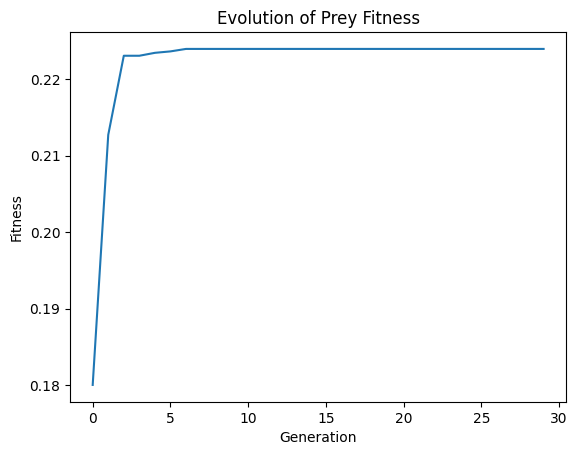

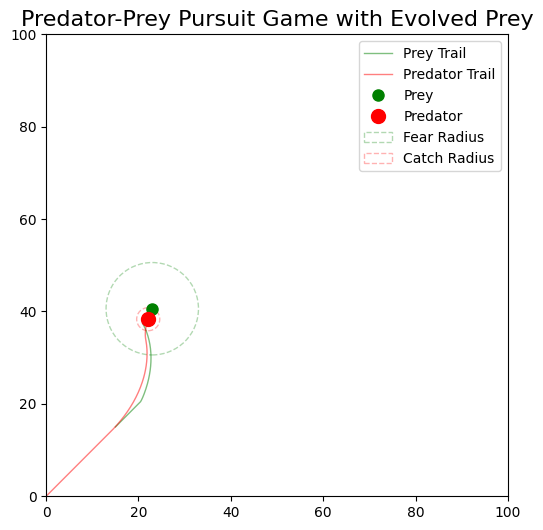

In [10]:
# Simulation parameters
simulation_params = {
    'dt': 0.1,
    'width': 100,
    'height': 100,
    'pred_max_speed': 3.0,
    'prey_max_speed': 3.0,
    'max_time': 60 
}
    
# Run evolution
prey_pop, fitness_history, best_prey_history, prey_history = evolve_preys(
    simulation_params,
    prey_pop_size=100,
    generations=30,
    mutation_rate=0.5,
    mutation_strength=0.5
)
# Get best individual from final generation
best_prey = best_prey_history[-1]
best_game = run_simulation(best_prey, simulation_params)

print("\nBEST PREY PARAMETERS")
print(f"Reaction Radius: \t{best_prey.react_radius:.2f}")
print(f"Evasion Angle:   \t{best_prey.evasion_angle:.2f} deg = {best_prey.evasion_angle * 180 / np.pi:.1f}°")
print(f"Evasion Time:    \t{best_prey.evasion_time:.2f} seconds")
print(f"Survival Time:   \t{best_game.get_survival_time():.2f} seconds")

visualize_evolution(fitness_history)
visualize_best_simulation(best_game)

## Analysis
The results of the simulation suggest that the prey population rapidly evolved their best evasion strategy within just a few generations. As shown in the fitness graph, prey fitness sharply increased and plateaued early, indicating fast convergence toward an optimal behavior. The best evolved prey had a reaction radius of 10.00 units, an evasion angle of 22.5°, and a delayed evasion time of 7.72 seconds, which together enabled it to survive 15.50 seconds on average in the predator-prey game. The trajectory plot reveals that despite the predator’s pursuit, the evolved prey was able to maneuver effectively and survive significantly longer than random or unevolved behaviors would permit. This suggests that the evolutionary process successfully tuned the prey's parameters to optimize evasion performance under the given simulation constraints.

The early plateau may lead us to believe the parameter space was not correctly explored, so as a sanity check we can plot a sample of the prey's distributions of traits and see if the whole range was traversed. The following plot is of 10 randomly picked preys and how their three different trait distributions look like.

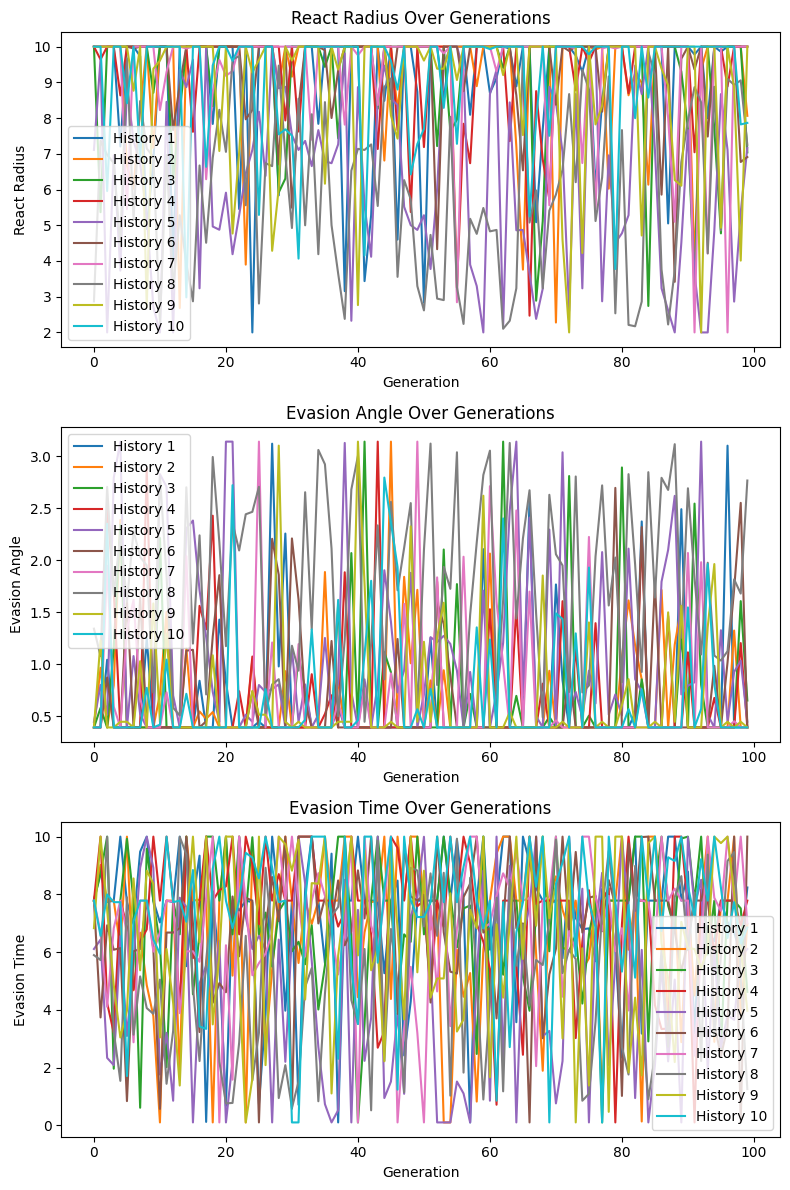

In [11]:
sampled_prey = random.sample(prey_history, 10)
visualize_trait_distributions(sampled_prey)

As can be seen from these plots, the space is being correctly searched, which leaves the fast convergence to be caused by the nature of the way the experiment is set up. The prey is severly disadvantaged therefore its best move is to instantly react. This means that it will have the biggest react radius to instantly trigger its fleeing. An interesting observation is that instead of zigzagging away, where the predator was able to speed up behind the prey, the best option for the prey was to ride out its zig for a long time, 7.7 seconds, and only turn once the prey was right behind it. 

Next, let's look at a slightly edited experiment, where we give the prey a bit more help. In this experiment, we will increase its maximum speed to be higher than the predator. Of course, in this scenario 

## Experiment 2: Faster Prey


BEST PREY PARAMETERS
Reaction Radius: 	9.07
Evasion Angle:   	0.39 deg = 22.5°
Evasion Time:    	2.66 seconds
Survival Time:   	100.10 seconds


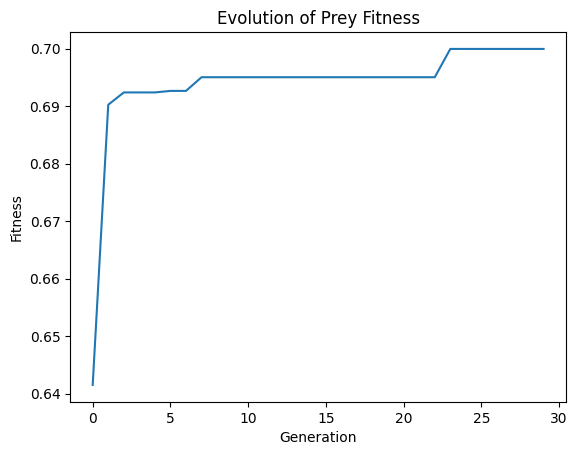

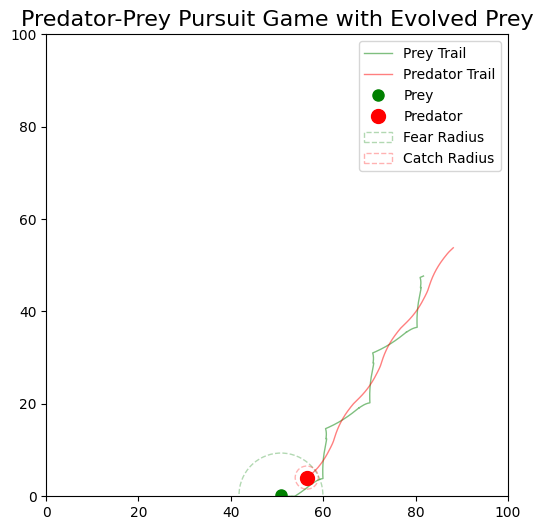

In [12]:
# Simulation parameters
simulation_params = {
    'dt': 0.1,
    'width': 100,
    'height': 100,
    'pred_max_speed': 3.0,
    'prey_max_speed': 5.0,
    'max_time': 100
}
    
# Run evolution
prey_pop, fitness_history, best_prey_history, prey_history = evolve_preys(
    simulation_params,
    prey_pop_size=100,
    generations=30,
    mutation_rate=0.5,
    mutation_strength=0.5
)
# Get best individual from final generation
best_prey = best_prey_history[-1]
best_game = run_simulation(best_prey, simulation_params)

print("\nBEST PREY PARAMETERS")
print(f"Reaction Radius: \t{best_prey.react_radius:.2f}")
print(f"Evasion Angle:   \t{best_prey.evasion_angle:.2f} deg = {best_prey.evasion_angle * 180 / np.pi:.1f}°")
print(f"Evasion Time:    \t{best_prey.evasion_time:.2f} seconds")
print(f"Survival Time:   \t{best_game.get_survival_time():.2f} seconds")

visualize_evolution(fitness_history)
visualize_best_simulation(best_game)

### Analysis

In Experiment #2, the prey had a higher maximum speed (5.0 vs. the predator's 3.0), which significantly impacted its ability to evade capture. The fitness curve shows a rapid rise and stabilization near 0.71, which again indicates that the evolutionary algorithm efficiently optimized prey behavior within a few generations. The best evolved prey had a smaller reaction radius (6.77 units) and a short evasion time (1.84 seconds), paired with a 22.5° evasion angle. These results suggest that a strategy of quick, short zigzags are better than the longer drawn out zigzag that was observed in experiment 1. This strategy (along with the fact the prey was faster) was highly effective, allowing the prey to survive the entire 100 second simulation. Overall, this experiment highlights how prey speed dominance simplifies the evolutionary challenge, enabling even modest evasive tactics to yield perfect survival.
As before we can take a quick look at the trait distributions over a sample of 10 preys.

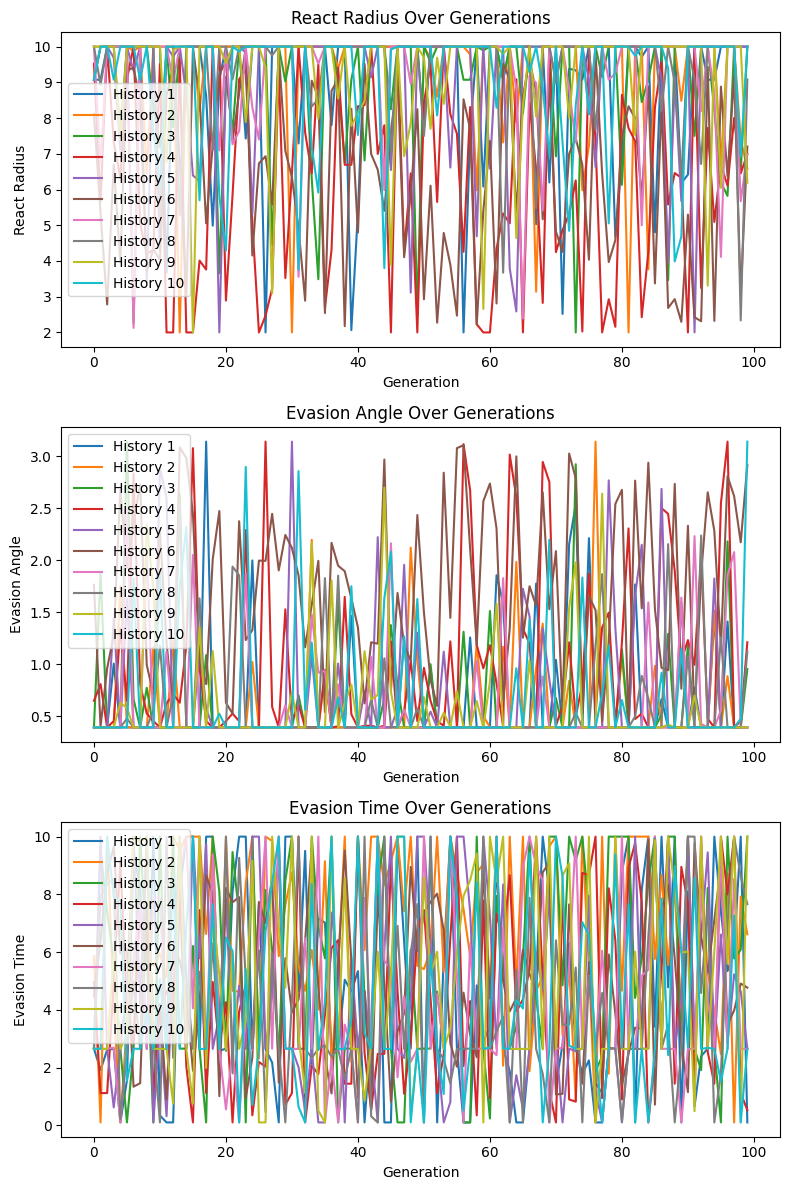

In [13]:
sampled_prey = random.sample(prey_history, 10)
visualize_trait_distributions(sampled_prey)

Here again we see a full exploration of the availabel parameter space.

### Conclusions

This implementation of evolutionary algorithms demonstrates how modeling evolution can successfully improve the performance of an agent in a predator-prey pursuit-evasion game. However, the structure of the game was quite limiting. The predator relied on a naive pure pursuit algorithm and was not subject to any evolutionary improvement.

It is likely that upgrading the predator's chasing behavior could have significantly impacted the outcome of Experiment 2. For instance, implementing a more advanced strategy, such as the Proportional Navigation (PN) algorithm used in homing missiles, (https://www.researchgate.net/publication/379147628_Missile_Guidance_using_Proportional_Navigation_and_Machine_Learning), might have guided the predator to pursue the prey more effectively. Additionally, incorporating the predator's navigation gain parameter (a key feaeture of PN that determines the strength of its predictive behavior) into its genome could have increased the performance of the predator even more.

The prey's movement structure was also simplistic. It only had access to a reaction radius, an evasion angle, and evasion time, which restricted the diveristy of possible evasion strategies. As observed in the evolutionary process, the fitness plateau was reached quite early, indicating the limitations of such a basic system. A more sophisticated algorithm, for example a stochastic zigzagging pattern, could make the prey's movements harder to predict. The prey's genome could consist of parameters controlling the randomness, frequency, and angle of directional changes, allowing for a more diverse range of evasion behaviors.

Another possible improvement, veering away from the domain of evolutionary algorithms,could be to include memory or learning mechanisms, such as a basic short-term memory of the predator’s position history, enabling it to infer the predator’s pursuit pattern and adapt accordingly.

These enhancements would provide a more balanced co-evolutionary environment in which both predator and prey are capable of improving in response to each other. This, in turn, could lead to more complex, adaptive, and realistic emergent behaviors—better reflecting the dynamic arms race found in natural predator-prey interactions.